In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from model import lorenz63

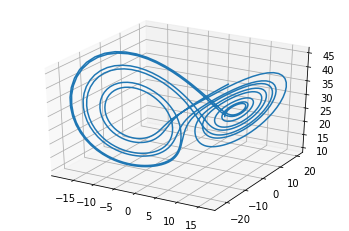

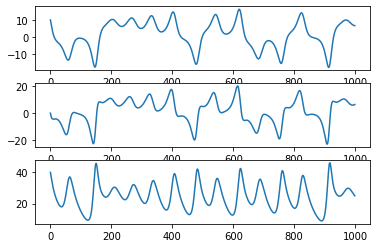

In [6]:
X = lorenz63([10, 0, 40], 1000, 0.01)

fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(X[:,0], X[:,1], X[:,2])

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(X[:,0])
axs[1].plot(X[:,1])
axs[2].plot(X[:,2])